# Ознакомление с заданием

Полное описание кейсового задания:

На основе больших данных о предыдущем опыте взаимодействия с клиентами разработать модель, позволяющую прогнозировать вероятность покупки клиентами дополнительных услуг в частности, приобретения машиномест в паркинге.
Среди клиентов компании - владельцев квартир необходимо выделить покупателей, наиболее склонных к покупке машиноместа. С такими клиентами будет проводиться коммуникация (смс, эл. письмо) с предложением приобрести машиноместо.
Входные данные представляют собой наборы признаков по клиентам на первое число каждого месяца за 1,5 года (sample данных).
Целевой признак равен 1, если в следующие 3 месяцев клиент купит машиноместо. После покупки машиноместа клиент исключается из наборов данных.
Результатом предсказания модели должен стать скор (значение от 0 до 1) по каждому клиенту - вероятность, что клиент купит машиноместо в следующие 3 месяцев.
Оцениваться результат будет метрикой ROC-AUC.

Есть колонки report_date (дата среза признаков) и client_id (уникальный идентификатор клиента).  Названия остальных колонок зашифрованы и представляют собой признаковое пространство для скоринга.

Среди признаков по клиенту представлены такие признаки как:
- история взаимодействия клиента с сайтом компании за разные периоды времени: просмотры, клики, заполнение форм обратной связи и т.п.
- интересы клиента, выявленные в ходе общения с клиентом
- история входящих и исходящих звонков по клиенту
- история встреч с клиентом
- избранные объекты недвижимости клиента
- имеющиеся договора клиента
- характеристики имеющихся ипотечных заявок
- вероятность наличия у клиента авто

Так как не все клиенты проходят через этап сайта, звонка, встречи, брони датасет получается разряженным - это специфика взаимодействия с клиентом. 


Необходимо иметь ввиду, что мы имеем дело с панельными данными - по каждому клиенту в датасете могут быть представлены несколько срезов за разные даты.
И в обучающем, и в тестовом датасете представлены не полные данные, а только подвыборки из ген совокупности.
При моделировании рекомендуется использовать кросс-валидацию.

Исходя из задания делаем некоторые преждевременные заметки:
- Предоставлены данные о предыдущем опыте взаимодействия с клиентами, также стоит учесть что каждому клиенту в датасете может быть представлено несколько срезов за разные даты.
- Так как предоставленные данные - это данные об активности пользователя на сайте, то пустые значения (NaN) могут быть полезны, так что скорее всего логичнее будет заполнить их нулями, чтобы модель их учитывала.
- В данном случае предстоит решить задачу бинарной классификации - предсказывать, купит клиент машиноместо или нет.
- Для проверки результатов будем использовать метрику AUC-ROC.

# Чтение файла и вывод основной информации
импорт библиотек и файла, знакомство с датасетом

In [1]:
# импорт основных библиотек для работы с датасетом и визуализациями
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv', low_memory=False).drop_duplicates() #загружаю датасет в переменную, сразу убирая дубликаты
df_validate = pd.read_csv('valid.csv', low_memory=False).drop_duplicates() #загружаю также датасет для валидации
# low_memory параметр выключен, чтобы не отображать ошибки, связанные с тем, что в колонках содержаться несколько типов данных -
# это мы проверим в дальнейшем

In [3]:
# смотрим первые строки датасета для понимания его структуры
df.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


In [4]:
df_validate.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4941670.0,4941670.0,4941670.0,NaN,NaN,NaN,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11789500.0,11789500.0,11789500.0,NaN,NaN,NaN,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7000000.0,7000000.0,7000000.0,NaN,NaN,NaN,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10391000.0,10391000.0,10391000.0,0.257348


In [5]:
# Вывожу размерность датасетов
print(df.shape)
print(df_validate.shape)

(14456, 2666)
(3642, 2666)


Первоначальное представление о данных:

- Датасет уже разделен на две части: для обучения и для проверки. Оба этих датасета нужно обработать, а потом разделить на train, test и validate выборки. Так как структура датасетов одинакова, основные действия будем делать с датасетом для обучения, и повторять их для датасета validate.
- Датасет для обучения содержит 14456 строк и 2666 колонок. Количество колонок достаточно большое, так что в основном нужно будет работать с ними, даже не зная какие именно данные они представляют.
- Из задания известно, что в столбце "client_id" представлены уникальные идентификаторы клиентов, а также что каждому клиенту в датасете может быть представлено несколько срезов за разные даты. Таким образом данные об одних и тех же клиентах могут повторяться, что может значительно повлиять на данные. Эта информация может пригодится.
- Также есть вероятность, что некоторые колонки содержат только значения Nan и/или 0. Датасет нужно проверить, отсеять колонки которые содержат слишком много пропущенных значений, а остальные заполнить с помощью медианных или средних значений, или же более сложными методами, например KNN.

# Предобработка данных (чистка датасета)

В самом начале проверяем датасет на наличие дубликатов столбцов и удаляем их - повторяющаяся информация не несет никакой пользы для модели

In [6]:
# Функция для определения дубликатов столбцов
def identify_duplicate_columns(df):
    duplicates = {}
    for column in df.columns:
        # Преобразуем столбец в строку для сравнения
        col_contents = df[column].fillna('').astype(str).values
        col_contents.sort()
        encoding = hash(tuple(col_contents))
        if encoding in duplicates:
            duplicates[encoding].append(column)
        else:
            duplicates[encoding] = [column]
    return duplicates

duplicate_columns = identify_duplicate_columns(df)

columns_to_remove = []
for duplicate_set in duplicate_columns.values():
    if len(duplicate_set) > 1:
        # Оставляем первый столбец, остальные добавляем в список для удаления
        columns_to_remove.extend(duplicate_set[1:])

print(f"Исходное количество столбцов: {df.shape[1]}")

# Удаляем дубликаты столбцов
df = df.drop(columns=columns_to_remove)
df_validate = df_validate.drop(columns=columns_to_remove)

print(f"Количество удаленных столбцов: {len(columns_to_remove)}")
print(f"Количество оставшихся столбцов: {df.shape[1]}")

Исходное количество столбцов: 2666
Количество удаленных столбцов: 456
Количество оставшихся столбцов: 2210


далее убираем колонки, которые содержат более чем 80% NaN-значений - такие колонки несут в себе слишком мало полезной информации

In [7]:
# дроп колонок по трешхолду
def drop_columns_with_nan(df, threshold_percent):
  nan_percentages = df.isnull().mean() * 100

  columns_to_drop = nan_percentages[nan_percentages > threshold_percent].index.tolist()
  print(f"Было найдено {len(columns_to_drop)} колонок с содержанием NaN значений больше чем {threshold_percent}%")
  return columns_to_drop

threshold = 80
columns_to_drop = drop_columns_with_nan(df, threshold)
df = df.drop(columns=columns_to_drop)
df_validate = df_validate.drop(columns=columns_to_drop)

Было найдено 1901 колонок с содержанием NaN значений больше чем 80%


после удаления большого количества ненужных колонок проверяем датасет на наличие колонок со смешанными типами - колонки с числовыми данными могут принять тип object из-за наличия NaN или ошибочных данных в них. Типы данных в таких колонках нужно урегулировать, или если в них содержится информация, которая не будет влиять на целевую переменную - удалить.

In [8]:
# Функция для проверки наличия смешанных типов данных в столбце
def has_mixed_types(column):
    return column.apply(type).nunique() > 1

# Применение функции ко всем столбцам
mixed_type_columns = df.columns[df.apply(has_mixed_types)]

print("Столбцы со смешанными типами данных:")
print(mixed_type_columns.tolist())

Столбцы со смешанными типами данных:
['col1454']


In [9]:
df['col1454'].unique().tolist()

['00f3d719-a6ec-4960-ba01-8372eb705443',
 '01febac0-b083-494e-8589-f98400074b94',
 '0278175e-c0bb-4e1e-bfe5-20db6811d3e2',
 '0364571d-5325-ed11-b823-005056b825cd',
 '065957a6-9b2a-435a-b561-024e9e8d9ad7',
 '07ca8162-5b7d-ed11-b824-005056b89b68',
 '0a154951-7e02-47d2-8d3d-480d0c84c206',
 '0aed31ac-cbe2-42cb-af39-8470ad01e8a4',
 '0b08a6bb-42f5-ec11-b822-005056b8a6d9',
 '0b498e8a-7c01-466d-b112-0c5785574f45',
 '0c6cc76e-bd09-4eec-b4c8-4ef642923b06',
 '0d4ec1c7-914f-ed11-b824-005056b89b68',
 '0d92e8bb-7312-ed11-b824-005056b89b68',
 '0ed64779-4334-4018-8b29-8ac3ad4353e0',
 '0f4a91d4-23f6-4745-9461-60d5cbf276ba',
 '0fe93355-5c69-455c-b7f5-b29f4b4db275',
 '101472b3-875b-428d-bcc2-21a30f13f124',
 '1071b34a-8ae6-40cf-96f2-328155d43be4',
 '12285d31-e47f-4044-b18a-6e590188fcf2',
 '13518128-3ebd-4b5f-9bdd-9220048a60de',
 '1361f472-a35e-4eb1-af5d-3308b40bcc3a',
 '1464db6a-d629-ed11-b824-005056b89b68',
 '15ce3286-7a62-ed11-b822-005056b8a6c4',
 '169e0338-95c5-4ab5-b94b-d7a55c501214',
 '16c5c669-adb2-

Выявилась только одна колонка - 1454, и в ней содержатся данные, похожие на коды, которые скорее всего являются уникальными для каждого сеанса или пользователя, а значит влияние этой колонки на целевую переменную будет крайне мало, поэтому удаляем колонку из обоих датасетов

In [10]:
df = df.drop(columns=['col1454'])
df_validate = df_validate.drop(columns=['col1454'])

после всех удалений для проверки выводим размерность трейн и тест датасетов - колонки в них должны быть одинаковыми, так что чтобы не допустить ошибок, в этом стоит удостовериться.

In [11]:
# проверяю, одинаково ли удаляются колонки по обоим датасетам
print(df.shape)
print(df_validate.shape)

(14456, 308)
(3642, 308)


с уверенностью что колонки в датасетах одинаковые переходим к следующему шагу - заполнение NaN-значений. Сначала вывожу тепловую карту, чтобы оценить их примерное содержание, хотя мы и так знаем, что максимальное их содержание в колонке - 80%, т.к. это было нашим трешхолдом, по которому мы удалили большую часть колонок.

<Axes: >

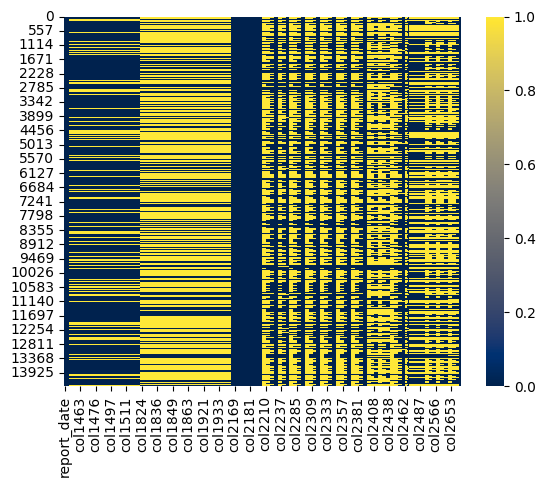

In [12]:
sns.heatmap(df.isnull(),cmap='cividis')

NaN-значений много, так что их нужно заполнить. Для этого мы выбираем метод из библиотеки sklearn - KNNImputer. Он заполнит пустые значения, основываясь на методе ближайших соседей.

<Axes: >

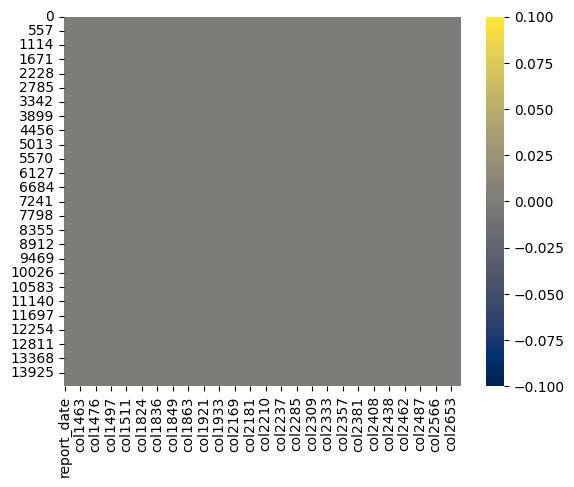

In [13]:
from sklearn.impute import KNNImputer

df_numeric = df.drop(columns=['report_date', 'client_id'])
df_validate_numeric = df_validate.drop(columns=['report_date', 'client_id'])

imputer = KNNImputer(n_neighbors=5)

df_imputed = imputer.fit_transform(df_numeric)
df_validate_imputed = imputer.transform(df_validate_numeric)

df_numeric = pd.DataFrame(df_imputed, columns=df_numeric.columns)
df_validate_numeric = pd.DataFrame(df_validate_imputed, columns=df_validate_numeric.columns)

df = pd.concat([df[['report_date', 'client_id']], df_numeric], axis=1)
df_validate = pd.concat([df_validate[['report_date', 'client_id']], df_validate_numeric], axis=1)

sns.heatmap(df.isnull(), cmap='cividis')

после заполнения пустых значений разделяем данные на 3 выборки - на которой будет обучаться модель, и 2 выборки для проверки - первая из того же датасета, на котором модель будет обучаться, а вторая - которую модель до этого не видела, что позволит отслеживать переобучение и получить более правдивые оценки по метрике.

In [14]:
# разделим фичи и таргет
from sklearn.model_selection import train_test_split

# Разделение данных на признаки и целевую переменную
X = df.drop(['report_date', 'client_id', 'target'], axis=1)
y = df['target']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размеров полученных выборок
print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

# Для тестовой выборки
X_valid = df_validate.drop(['report_date', 'client_id', 'target'], axis=1)
y_valid = df_validate['target']
print("Размер валидационной выборки:", X_valid.shape)

Размер обучающей выборки: (11564, 305)
Размер тестовой выборки: (2892, 305)
Размер валидационной выборки: (3642, 305)


In [15]:
# кодируем категориальные колонки с помощью OrdinalEncoder 
from sklearn.preprocessing import OrdinalEncoder

def encoding_data(selection):
  ordinal_encoder = OrdinalEncoder()
  
  categorical_columns = selection.select_dtypes(include=['object']).columns.tolist()
  selection[categorical_columns] = selection[categorical_columns].astype(str)

  encoded_data = ordinal_encoder.fit_transform(selection[categorical_columns])
  selection[categorical_columns] = encoded_data.astype(int)
  
  return selection
  


X_train = encoding_data(X_train)
X_test = encoding_data(X_test)
X_valid = encoding_data(X_valid)


# Баланс классов, SMOTE

После разделения на выборки можно продолжать работу с той, на которой будет обучаться модель. Для начала проверим баланс классов в целевой переменной, т.к. в реальных данных зачастую возникает достаточно сильная разница, которая может влиять на работу моделей.

Баланс классов в обучающей выборке:
target
0.0    0.969474
1.0    0.030526
Name: proportion, dtype: float64


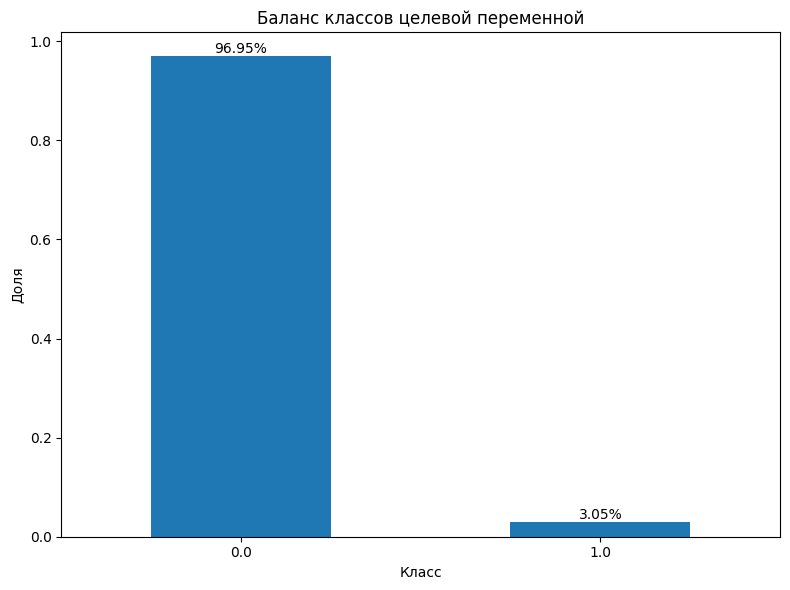


Абсолютные значения:
target
0.0    11211
1.0      353
Name: count, dtype: int64


In [16]:
# Вывод баланса классов для целевой переменной
class_balance = y_train.value_counts(normalize=True)
print("Баланс классов в обучающей выборке:")
print(class_balance)

# Визуализация баланса классов
plt.figure(figsize=(8, 6))
class_balance.plot(kind='bar')
plt.title('Баланс классов целевой переменной')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for i, v in enumerate(class_balance):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Вывод абсолютных значений
print("\nАбсолютные значения:")
print(y_train.value_counts())

как и предполагалось, разница между классами колосальная, так что её нужно исправить. Делать это мы будем с помощью метода SMOTE, который генерирует синтетические данные на основе уже существующих для класса, который имеет меньшее содержание в датасете. Таким образом мы сможем достичь равномерного распределения.

Баланс классов в сбалансированной обучающей выборке:
target
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


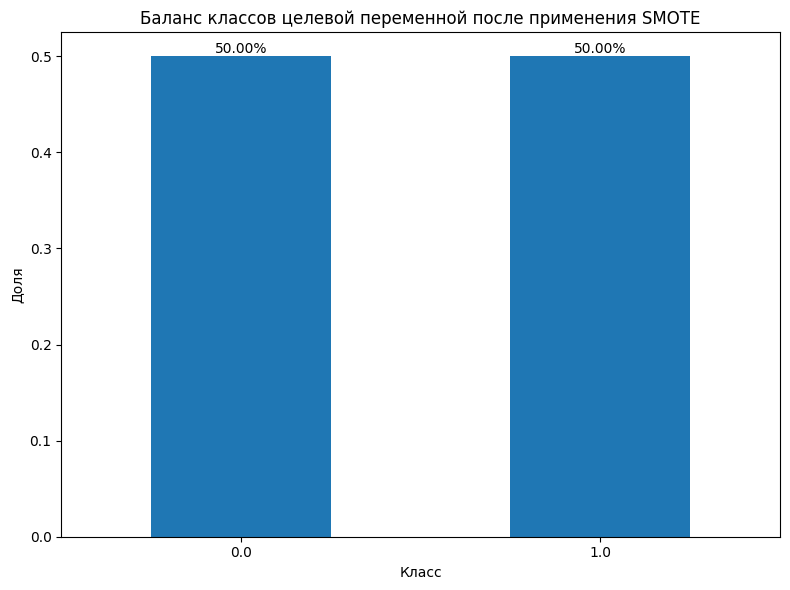

In [17]:
from imblearn.over_sampling import SMOTE

# Создание объекта SMOTE
smote = SMOTE(random_state=42)

# Применение SMOTE к обучающей выборке
X_train, y_train = smote.fit_resample(X_train, y_train)

# Проверка нового баланса классов
class_balance_balanced = y_train.value_counts(normalize=True)
print("Баланс классов в сбалансированной обучающей выборке:")
print(class_balance_balanced)

# Визуализация нового баланса классов
plt.figure(figsize=(8, 6))
class_balance_balanced.plot(kind='bar')
plt.title('Баланс классов целевой переменной после применения SMOTE')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for i, v in enumerate(class_balance_balanced):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# PCA

Баланс классов достигнут, так что можно приступать к выбору главных признаков, которые имеют большее влияние в датасете. Для этого мы воспользуемся методом PCA из библиотеки sklearn, который также называется методом главных компонент. Для этого стандартизируем данные и применяем к ним PCA. Он позволяет уменьшить размерность данных, сохранив при этом как можно больше информации.

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Выбор наиболее значимых признаков с помощью PCA
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])
X_valid_scaled = scaler.transform(X_valid[numerical_cols])

pca = PCA(n_components=0.92)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_valid_pca = pca.transform(X_valid_scaled)


print(f'Number of components: {pca.n_components_}')

Number of components: 66


# Модели

После уменьшения размерности можно приступать к тестированию моделей. Ниже представлены самые результативные из всех, которые были протестированы.

In [19]:
# импортирую методы для метрики ROC-AUC
from sklearn.metrics import roc_auc_score, roc_curve

ROC-AUC на тестовой выборке: 0.9310284927534989
ROC-AUC на валидационной выборке: 0.7815444715612501


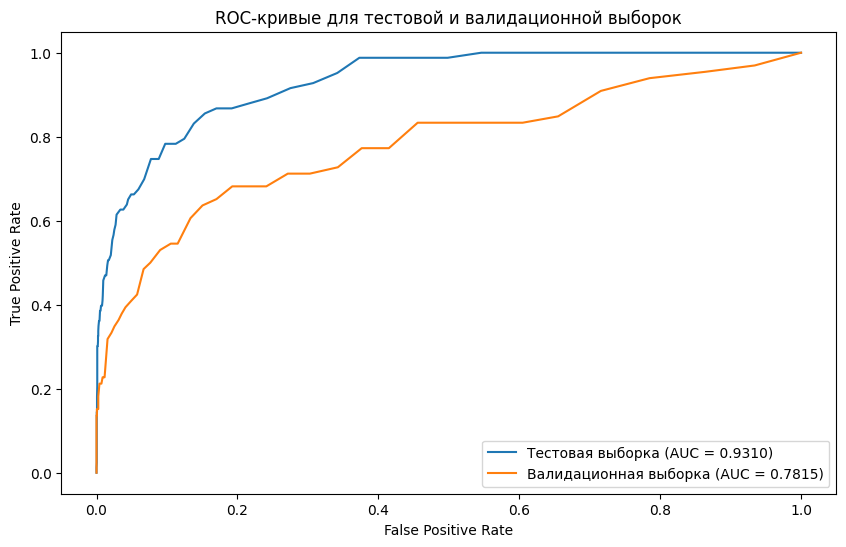

In [20]:
# модель RandomForestClassifier 100 деревьев
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = rf.predict_proba(X_test_pca)[:, 1]
roc_auc_test_rf_100 = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_rf_100}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_rf_100:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = rf.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_rf_100 = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_rf_100}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_rf_100:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()

ROC-AUC на тестовой выборке: 0.9370482999995711
ROC-AUC на валидационной выборке: 0.7959523930580976


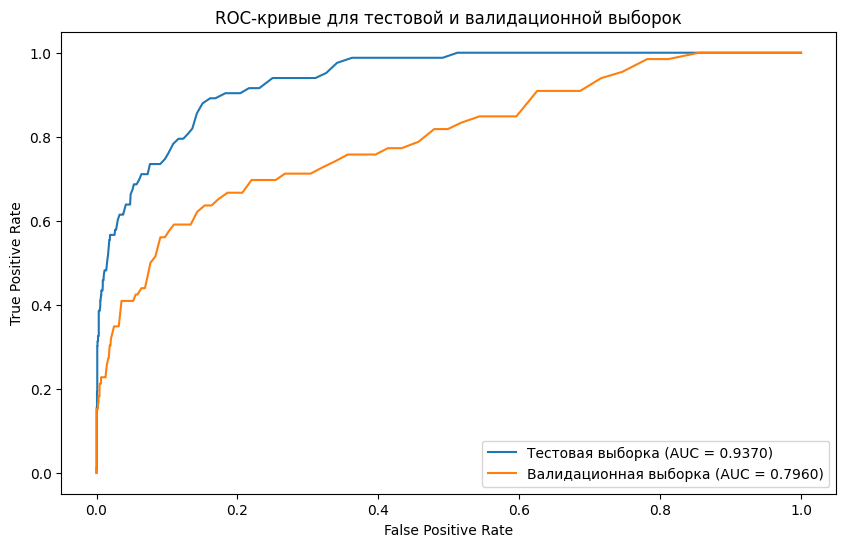

In [21]:
# модель RandomForestClassifier 200 деревьев
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = rf.predict_proba(X_test_pca)[:, 1]
roc_auc_test_rf_200 = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_rf_200}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_rf_200:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = rf.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_rf_200 = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_rf_200}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_rf_200:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()

ROC-AUC на тестовой выборке: 0.8586556979073289
ROC-AUC на валидационной выборке: 0.6769964748152668


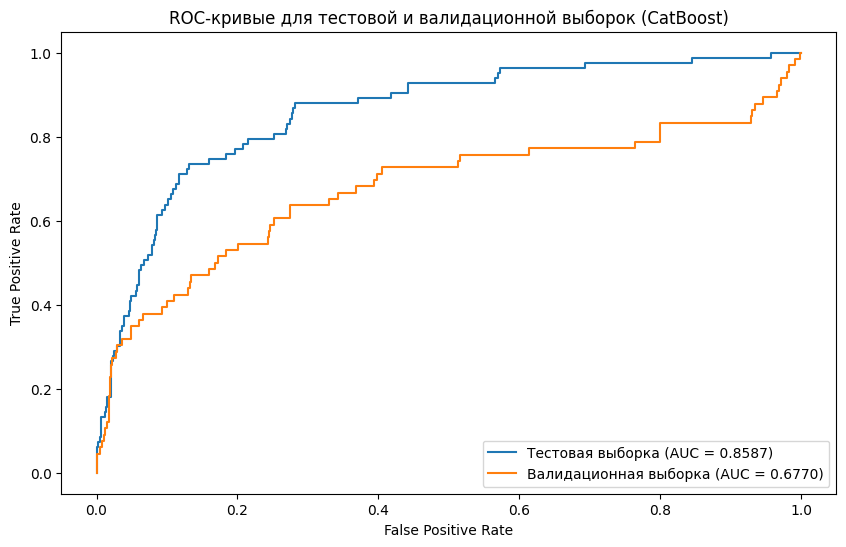

In [22]:
# модель CatBoost 
from catboost import CatBoostClassifier

# Создание и обучение модели CatBoost
model = CatBoostClassifier(iterations=1000, learning_rate=0.01, random_state=42, depth=5, verbose=False)
model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_cb = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_cb}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_cb:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_cb = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_cb}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_cb:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок (CatBoost)')
plt.legend()
plt.show()

ROC-AUC на тестовой выборке: 0.7878420052584849
ROC-AUC на валидационной выборке: 0.7529659006169074


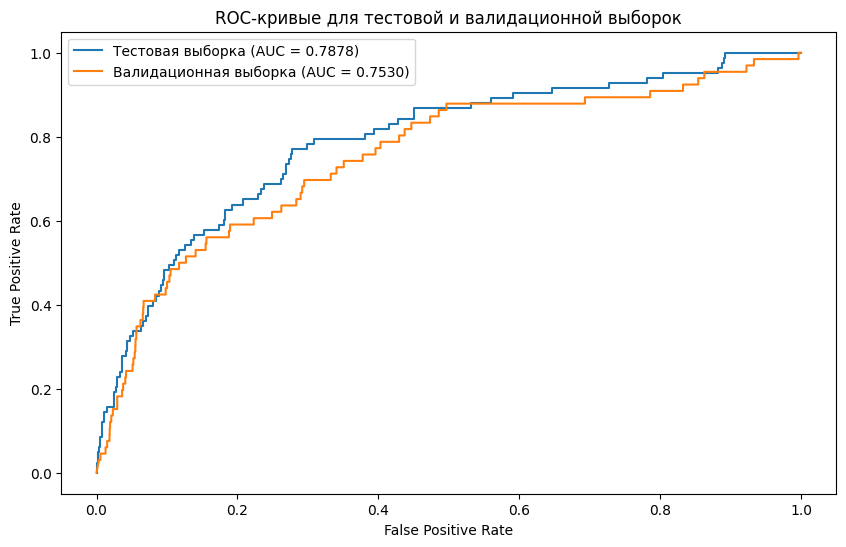

In [23]:
# модель LogisticRegression
from sklearn.linear_model import LogisticRegression

# Создание и обучение модели логистической регрессии с L1 регуляризацией
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_lr = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_lr}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_lr:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_lr = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_lr}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_lr:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()

C:\Users\Илья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ROC-AUC на тестовой выборке: 0.7615174117616783
ROC-AUC на валидационной выборке: 0.6697


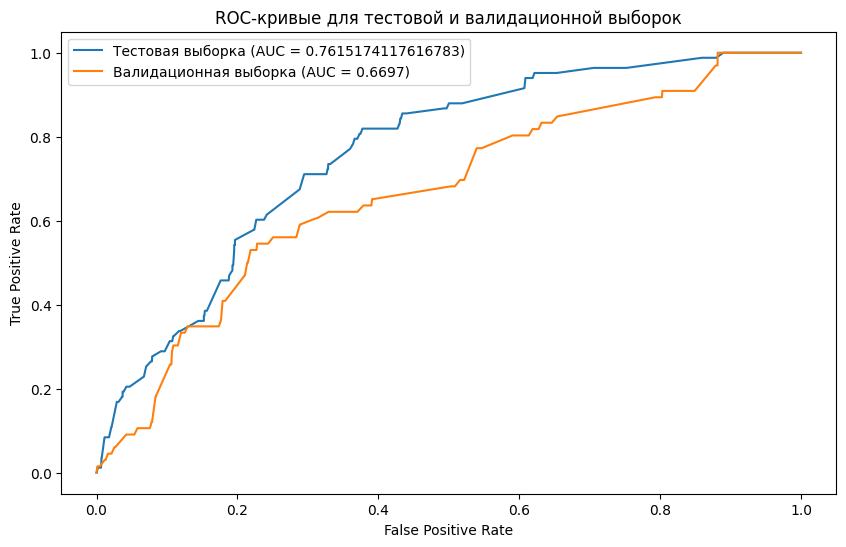

In [24]:
# модель AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=10,learning_rate=0.6)
model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_ada = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_ada}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_ada})')

# Проверка на валидационной выборке
y_pred_proba_valid = model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_ada = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_ada:.4f}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_ada:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()

ROC-AUC на тестовой выборке: 0.940951416917224
ROC-AUC на валидационной выборке: 0.7727569317334418


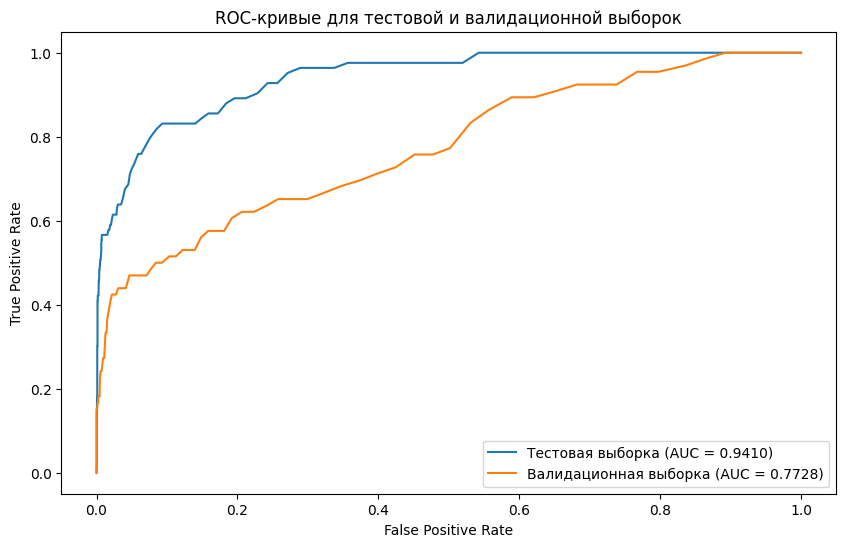

In [25]:
# модель ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_estimators=200, random_state=42)
et_model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = et_model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_et = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_et}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_et:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = et_model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_et = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_et}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_et:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()

ROC-AUC на тестовой выборке: 0.8867066700407895
ROC-AUC на валидационной выборке: 0.6974548335706053


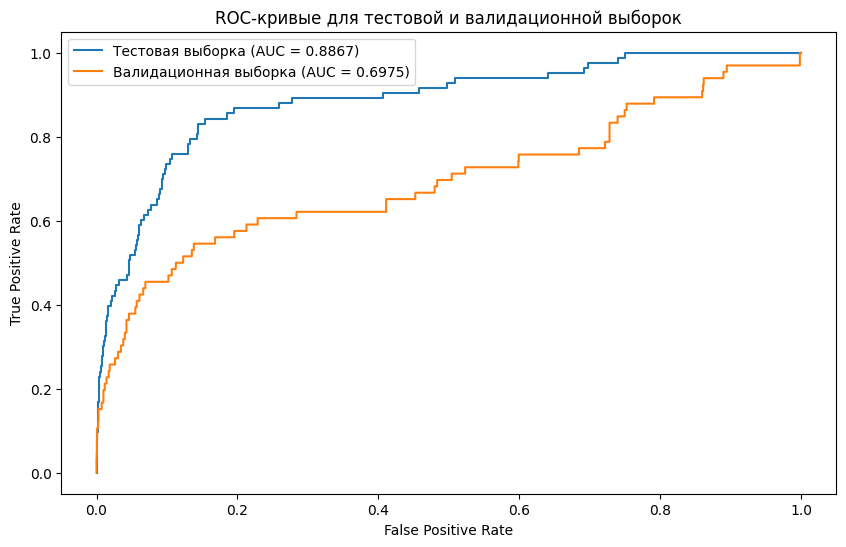

In [26]:
# модель HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model = HistGradientBoostingClassifier(max_iter=100, random_state=42)
model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_hgb = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_hgb}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_hgb:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_hgb = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_hgb}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_hgb:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()

# уменьшение кол-ва признаков

После некоторого количества тестов моделей была предпринята попытка уменьшить размерность основываясь на результатах влияния признаков на целевую переменную, полученную на основе результатов модели, но, к сожалению, это не привело к желаемому результату - оценка метрики оставалась ниже чем у моделей, которые были протестированы до этого. Из этого можно сделать вывод, что удалённые признаки имели достаточно влияния, чтобы не исключать их из выборки для модели.

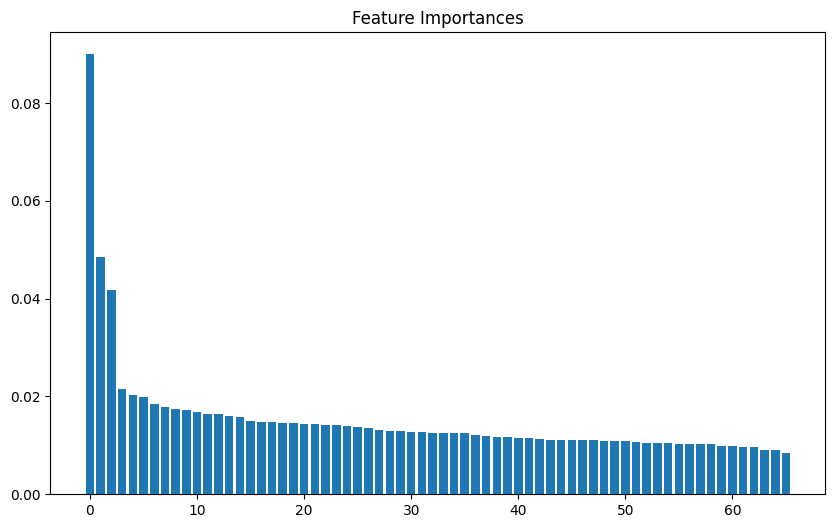

In [27]:
# Выбираем список влияния колонок на основе результатов модели RandomForestClassifier
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# создаем график для наглядности
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_pca.shape[1]), importances[indices])
plt.show()

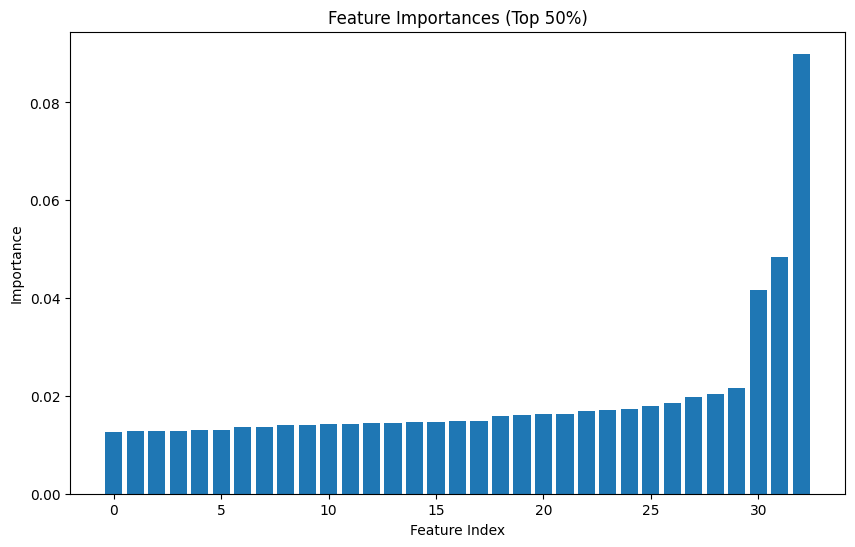

In [28]:
# Получаем важности признаков
importances = rf.feature_importances_
indices = np.argsort(importances)

# Определяем количество признаков для удаления (половина)
n_features_to_keep = len(importances) // 2

# Выбираем наиболее важные признаки
top_feature_indices = indices[-n_features_to_keep:]

# Создаем новые наборы данных только с важными признаками
X_train_important = X_train_pca[:, top_feature_indices]
X_test_important = X_test_pca[:, top_feature_indices]
X_valid_important = X_valid_pca[:, top_feature_indices]

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Top 50%)")
plt.bar(range(n_features_to_keep), importances[top_feature_indices])
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

ROC-AUC на тестовой выборке: 0.9500808502790085
ROC-AUC на валидационной выборке: 0.7632724052606603


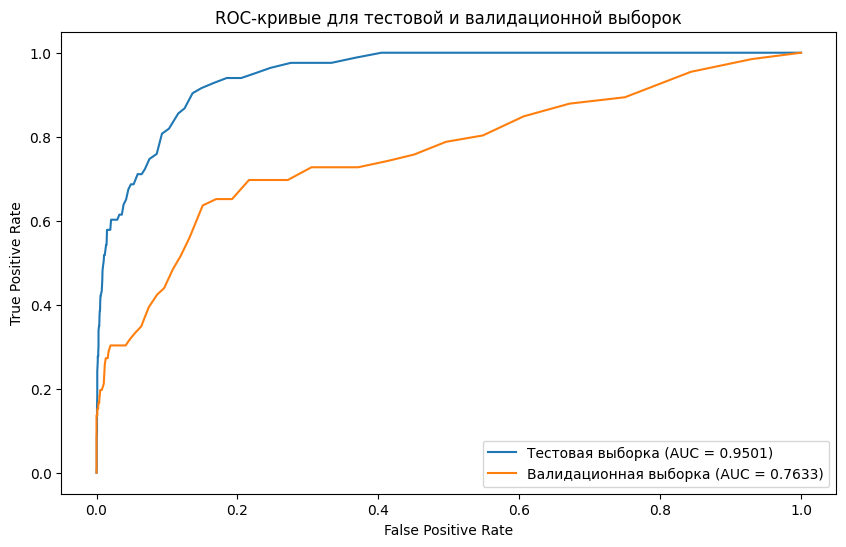

In [29]:
# модель рандомфорест 200 деревьев c меньшей выборкой
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_important, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = rf.predict_proba(X_test_important)[:, 1]
roc_auc_test_rf_100_important = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_rf_100_important}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_rf_100_important:.4f})')

# Проверка на валидационной выборке
y_pred_proba_valid = rf.predict_proba(X_valid_important)[:, 1]
roc_auc_valid_rf_100_important = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_rf_100_important}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_rf_100_important:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()

# Ансамбль

После тестов моделей, мы решили рассмотреть вариант немного сложнее - ансамбль из моделей, который будет предсказывать целевую переменную на основе "голосования" и взвешивания предсказаний моделей для каждого класса - VotingClassifier. Для него мы решили использовать уже протестированные модели, а именно RandomForestClassifier, LogisticRegression и AdaBoostClassifier.

C:\Users\Илья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ROC-AUC на тестовой выборке: 0.8945515061313248
ROC-AUC на валидационной выборке: 0.8029879330214901


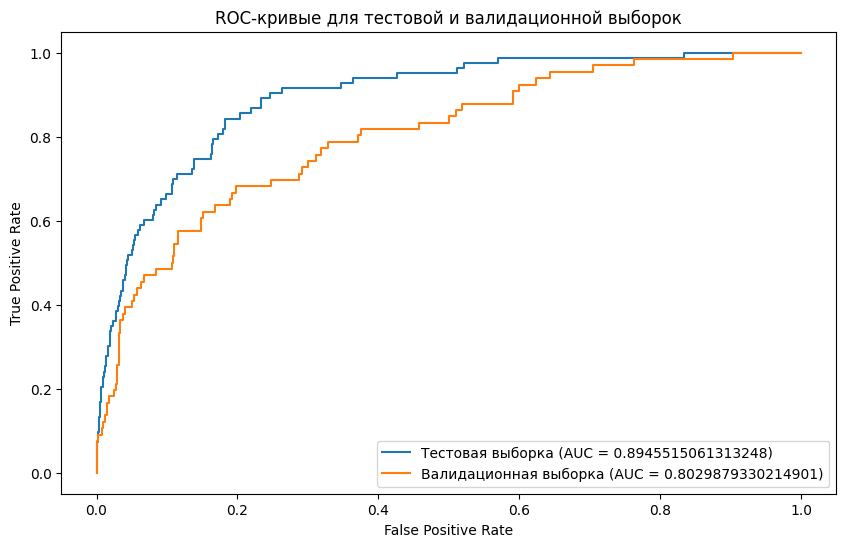

In [30]:
# ансамбль VotingClassifier на основе RandomForestClassifier, LR, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# Define individual models
rf_model = RandomForestClassifier(
  n_estimators = 200,
  min_samples_split = 23,
  min_samples_leaf= 2,
  max_features = 'sqrt',
  max_depth = 14,
  bootstrap = False)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
ada_model = AdaBoostClassifier(n_estimators=10, learning_rate=0.6, random_state=42)

voter_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('ada', ada_model)
    ],
    voting='soft'
)

voter_model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = voter_model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_voter = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_voter}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_voter})')

# Проверка на валидационной выборке
y_pred_proba_valid = voter_model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_voter = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_voter}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_voter})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()


C:\Users\Илья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ROC-AUC на тестовой выборке: 0.9247985176733992
ROC-AUC на валидационной выборке: 0.8166395498610264


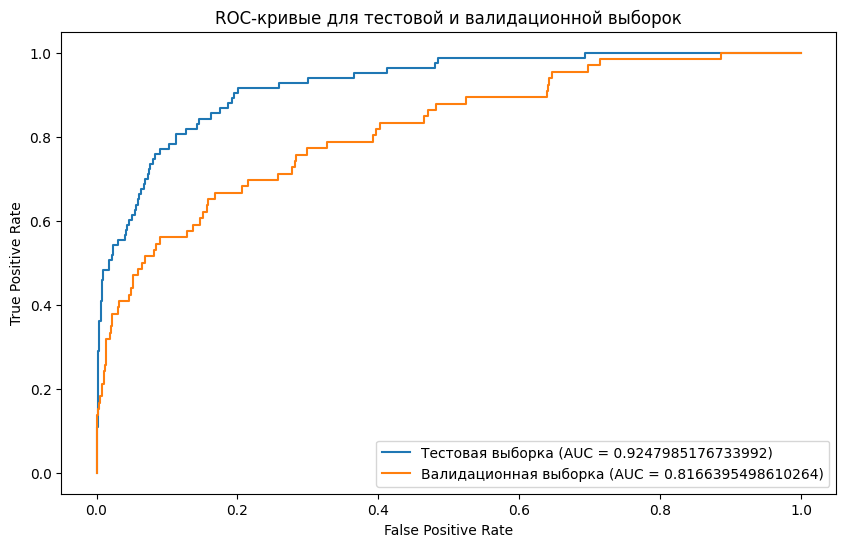

In [31]:
rf_model = RandomForestClassifier(
  n_estimators = 200,
  min_samples_split = 23,
  min_samples_leaf= 2,
  max_features = 'sqrt',
  max_depth = 14,
  bootstrap = False,
  random_state = 42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
ada_model = AdaBoostClassifier(n_estimators=10, learning_rate=0.6, random_state=42)
et = ExtraTreesClassifier(n_estimators=200, random_state=42)

voter_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('et', et),
        ('ada', ada_model),
    ],
    voting='soft'
)

voter_model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = voter_model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_voter_2 = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_voter_2}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_voter_2})')

# Проверка на валидационной выборке
y_pred_proba_valid = voter_model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_voter_2 = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_voter_2}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_voter_2})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()

ROC-AUC на тестовой выборке: 0.9193899128017945
ROC-AUC на валидационной выборке: 0.798123856009762


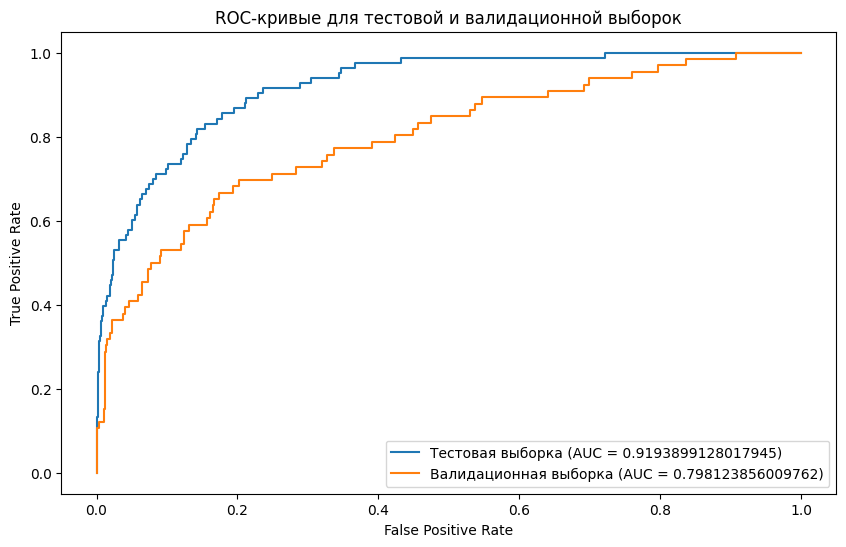

In [32]:
rf_model = RandomForestClassifier(
  n_estimators = 200,
  min_samples_split = 23,
  min_samples_leaf= 2,
  max_features = 'sqrt',
  max_depth = 14,
  bootstrap = False,
  random_state = 42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
ada_model = AdaBoostClassifier(n_estimators=10, learning_rate=0.6, random_state=42)
et = ExtraTreesClassifier(n_estimators=200, random_state=42)
cb_model = CatBoostClassifier(iterations=1000, learning_rate=0.01, random_state=42, depth=5, verbose=False)

voter_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('et', et),
        ('cb', cb_model),
    ],
    voting='soft'
)

voter_model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = voter_model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_voter_3 = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_voter_3}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_voter_3})')

# Проверка на валидационной выборке
y_pred_proba_valid = voter_model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid_voter_3 = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_voter_3}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_voter_3})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()

# Общие результаты моделей

после выполнения всех моделей можно вывести общие результаты - в виде текста и графика, чтобы проанализировать какая из моделей сработала лучше и выбрать итоговую.

In [33]:
print('------- итоговые показатели ----------')
print(f'AUC-ROC voter: {roc_auc_valid_voter}')
print(f'AUC-ROC voter v2: {roc_auc_valid_voter_2}')
print(f'AUC-ROC voter v3: {roc_auc_valid_voter_3}')
print(f'AUC-ROC rfc-100: {roc_auc_valid_rf_100}')
print(f'AUC-ROC rfc-100 important features: {roc_auc_valid_rf_100_important}')
print(f'AUC-ROC rfc-200: {roc_auc_valid_rf_200}')
print(f'AUC-ROC lr: {roc_auc_valid_lr}')
print(f'AUC-ROC ada: {roc_auc_valid_ada}')
print(f'AUC-ROC et: {roc_auc_valid_et}')
print(f'AUC-ROC cb: {roc_auc_valid_cb}')
print(f'AUC-ROC cb: {roc_auc_valid_hgb}')


------- итоговые показатели ----------
AUC-ROC voter: 0.8029879330214901
AUC-ROC voter v2: 0.8166395498610264
AUC-ROC voter v3: 0.798123856009762
AUC-ROC rfc-100: 0.7815444715612501
AUC-ROC rfc-100 important features: 0.7632724052606603
AUC-ROC rfc-200: 0.7959523930580976
AUC-ROC lr: 0.7529659006169074
AUC-ROC ada: 0.669655870788421
AUC-ROC et: 0.7727569317334418
AUC-ROC cb: 0.6769964748152668
AUC-ROC cb: 0.6974548335706053


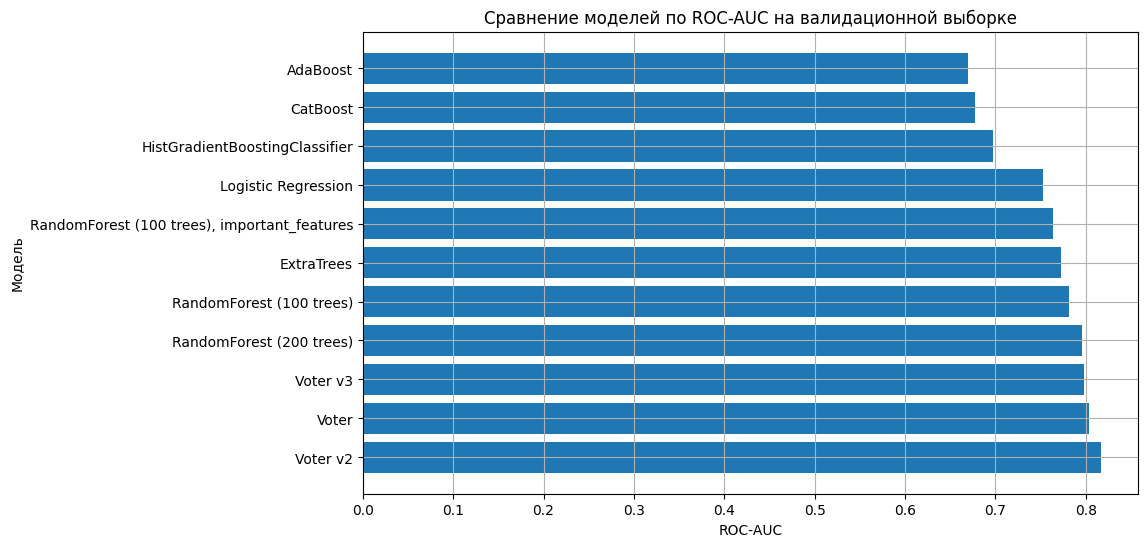

In [34]:
import matplotlib.pyplot as plt

# Значения AUC-ROC для валидационной выборки
roc_auc_values = [roc_auc_valid_voter, roc_auc_valid_voter_2, roc_auc_valid_voter_3, roc_auc_valid_hgb, roc_auc_valid_rf_100, roc_auc_valid_rf_100_important, roc_auc_valid_rf_200, roc_auc_valid_lr, roc_auc_valid_ada, roc_auc_valid_et, roc_auc_valid_cb]

# Названия моделей
model_names = ['Voter', 'Voter v2', 'Voter v3', 'HistGradientBoostingClassifier', 'RandomForest (100 trees)', 'RandomForest (100 trees), important_features', 'RandomForest (200 trees)', 'Logistic Regression', 'AdaBoost', 'ExtraTrees', 'CatBoost']

# Сортировка значений AUC-ROC по убыванию
sorted_indices = sorted(range(len(roc_auc_values)), key=lambda k: roc_auc_values[k], reverse=True)
roc_auc_values = [roc_auc_values[i] for i in sorted_indices]
model_names = [model_names[i] for i in sorted_indices]

# Строим график
plt.figure(figsize=(10, 6))
plt.barh(range(len(roc_auc_values)), roc_auc_values, align='center')
plt.yticks(range(len(roc_auc_values)), model_names)
plt.xlabel('ROC-AUC')
plt.ylabel('Модель')
plt.title('Сравнение моделей по ROC-AUC на валидационной выборке')
plt.grid(True)
plt.show()

# Итоговая модель

Исходя из оценок метрики AUC-ROC самой лучшей моделью оказалась вторая версия VotingClassifier, обьединившая в ансамбль четыре модели - RandomForestClassifier, LogisticRegression, AdaBoostClassifier и ExtraTreesClassifier.

Также для более понятного графика немного улучшаю его, и на основе работы этой модели сохраняю результаты предсказаний.

C:\Users\Илья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ROC-AUC на тестовой выборке: 0.9247985176733992
Файл submission_file.csv сохранен.
ROC-AUC на валидационной выборке: 0.8166395498610264


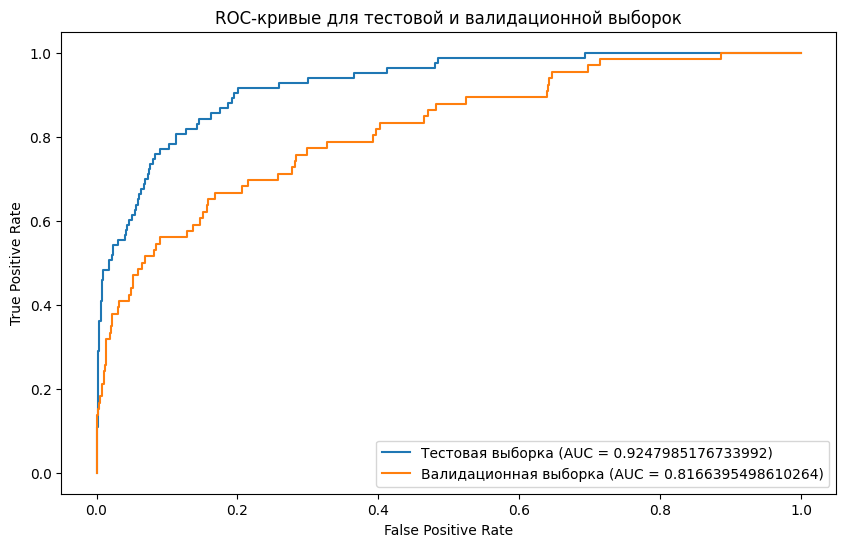

In [35]:
# модель VotingClassifier с лучшими результатами
rf_model = RandomForestClassifier(
  n_estimators = 200,
  min_samples_split = 23,
  min_samples_leaf= 2,
  max_features = 'sqrt',
  max_depth = 14,
  bootstrap = False,
  random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
ada_model = AdaBoostClassifier(n_estimators=10, learning_rate=0.6, random_state=42)
et = ExtraTreesClassifier(n_estimators=200, random_state=42)

voter_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('et', et),
        ('ada', ada_model),
    ],
    voting='soft'
)

voter_model.fit(X_train_pca, y_train)

# Проверка на тестовой выборке
y_pred_proba_test = voter_model.predict_proba(X_test_pca)[:, 1]
roc_auc_test_voter_2 = roc_auc_score(y_test, y_pred_proba_test)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test_voter_2}')

# Построение ROC-кривой для тестовой выборки
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Тестовая выборка (AUC = {roc_auc_test_voter_2})')

# Проверка на валидационной выборке
y_pred_proba_valid = voter_model.predict_proba(X_valid_pca)[:, 1]

# Создание датафрейма с идентификаторами клиентов и предсказаниями
submission_df = pd.DataFrame({
    'client_id': df_validate['client_id'],
    'target': y_pred_proba_valid
})

# Сохранение датафрейма с результатами в csv-файл
submission_df.to_csv('submission_file.csv', index=False)

print("Файл submission_file.csv сохранен.")


roc_auc_valid_voter_2 = roc_auc_score(y_valid, y_pred_proba_valid)
print(f'ROC-AUC на валидационной выборке: {roc_auc_valid_voter_2}')

# Построение ROC-кривой для валидационной выборки
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba_valid)
plt.plot(fpr_valid, tpr_valid, label=f'Валидационная выборка (AUC = {roc_auc_valid_voter_2})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для тестовой и валидационной выборок')
plt.legend()
plt.show()

# Заключение

В ходе работы полученные данные были обработаны, была подобрана модель, которая предсказывает склонен ли клиент к покупке машиноместа и сделаны предсказания, которые были сохранены в отдельный файл submission_file.csv, согласно выданному заданию. 

Итоговой моделью стала ансамблевая VoterClassifier, использующая еще 4 модели - RandomForestClassifier, LogisticRegression, AdaBoostClassifier и ExtraTreesClassifier.

Лучшим результатом по метрике AUC-ROC можно считать 0.8166395498610264, или, если округлять, 0.82 (по valid выборке). Это можно считать достаточно хорошим результатом для поставленной задачи, хотя и можно было добиться большего.

Доработать этот результат можно углубившись ещё сильнее в разнообразные виды моделей и протестировав их большее количество, продолжая использовать ансамбли (возможно другие) либо найдя способ лучше и достичь оценки по метрике больше 0.9 - зачастую этого полностью достаточно для работодателя, если речь не идёт о медицине.
Также можно поработать с обработкой данных - в самом начале работы мы выявили корреляцию между некоторыми соседними колонками, но не упомянули об этом в отчёте, так как не смогли реализовать качественное решение - наши попытки обьединения колонок не увенчались успехом, группы определялись слишком хаотично, что могло достаточно сильно повлиять на качество данных (в плохую сторону). Тем не менее способ, который мы предложили для уменьшения размерности - PCA, можно назвать некой альтернативой, т.к. он также включает в себя вычисление зависимостей между колонок, но узнать какой из этих способов повёл бы себя эффективнее нам к сожалению не удалось.

